In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf

In [2]:
import math
def sigmoid(x):
    try:
        sig = 1 / (1 + math.exp(-x))
    except:
        sig = 0
    return sig

In [3]:
def relu(x, bound = 20):
    return min(max(0,x),bound)

In [4]:
def SRN_garch(alpha, beta, gamma0, gamma1, v1, v2, nun_lin_func, returns):
    iT = len(returns)
    sigma_2 = np.zeros(iT)
    w = np.zeros(iT)
    h = np.zeros(iT)
    for i in range(iT):
        if i == 0:
            sigma_2[i] = 0.1/(1- alpha - beta)
            h[i] = 0.1/(1- alpha - beta)
            w[i] = 0.1/(1- alpha - beta)
        else:
            h[i] = nun_lin_func(v1 * returns[i-1] + v2 * sigma_2[i-1])
            w[i] = gamma0 + gamma1 * h[i]
            sigma_2[i] = w[i] + alpha * returns[i-1]**2 + beta * sigma_2[i-1]
    return sigma_2, w, h

[*********************100%***********************]  1 of 1 completed


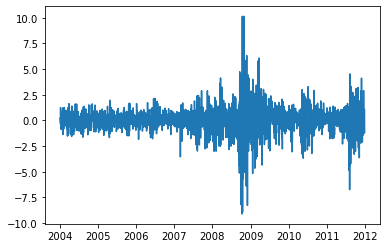

In [5]:
data = yf.download("^GSPC", start="2004-01-01", end="2012-01-01")

data['pct_change'] = data.Open.pct_change()

data['log_ret'] = np.log(data.Open) - np.log(data.Open.shift(1))


data['log_ret * 100'] = data['log_ret'] * 100

returns = data['log_ret * 100'].values[1:]

plt.plot(data['log_ret * 100'])

# Model 1:
$h$ is a vector and $\gamma_1$ is a vector
\begin{align}
w_t = \gamma_0 + \gamma_1' h_t
\end{align}
with $h_t$
\begin{align}
    h_t &= \begin{bmatrix}
           \phi(v_1 y_{t-1} + b_1) \\
           \phi(v_2 y_{t-1}^2 + b_2) \\
           \phi(v_3 \sigma_{t-1}^2 + b_3) \\
           \phi(v_4 w_{t-1} + b_4)
         \end{bmatrix}
  \end{align}

In [6]:
func_choice = relu

In [7]:
def SRN_garch_hvec(alpha, beta, gamma0, gamma1_1, gamma1_2, gamma1_3, gamma1_4, v_1, v_2, v_3, v_4, b_1, b_2, b_3, b_4, nun_lin_func, returns):
    iT = len(returns)
    sigma_2 = np.zeros(iT)
    w = np.zeros(iT)
    p = 4
    h = np.zeros(iT*p)
    h = h.reshape(iT,p)
    for i in range(iT):
        if i == 0:
            sigma_2[i] = 0.1/(1- alpha - beta)
            for l in range(p):
                h[l,0] = 0.1/(1- alpha - beta)
            w[i] = 0.1/(1- alpha - beta)
        else:
            h[i,0] = nun_lin_func(v_1 * returns[i-1] + b_1)
            h[i,1] = nun_lin_func(v_2 * returns[i-1]**2 + b_2)
            h[i,2] = nun_lin_func(v_3 * sigma_2[i-1] + b_3)
            h[i,3] = nun_lin_func(v_4 * w[i-1] + b_4)
            w[i] = gamma0 + gamma1_1 * h[i,0] + gamma1_2 * h[i,1] + gamma1_3 * h[i,2] + gamma1_4 * h[i,3]
            sigma_2[i] = w[i] + alpha * returns[i-1]**2 + beta * sigma_2[i-1]
    return sigma_2, w, h

def SRN_garch_hvec_loglike(start_v, nun_lin_func, returns):
    iT = len(returns)
    alpha = start_v[0]
    beta = start_v[1]
    gamma0 = start_v[2]
    gamma1_1 = start_v[3]
    gamma1_2 = start_v[4]
    gamma1_3 = start_v[5]
    gamma1_4 = start_v[6]
    v_1 = start_v[7]
    v_2 = start_v[8]
    v_3 = start_v[9]
    v_4 = start_v[10]
    b_1 = start_v[11]
    b_2 = start_v[12]
    b_3 = start_v[13]
    b_4 = start_v[14]
    
    sigma_2 = SRN_garch_hvec(alpha, beta, gamma0, gamma1_1, gamma1_2, gamma1_3, gamma1_4, v_1, v_2, v_3, v_4, b_1, b_2, b_3, b_4, nun_lin_func, returns)[0]
    LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)
    return LogL

In [8]:
cons = ({"type": "ineq", "func" : lambda x: np.array(x)})
vP0 = (0.1, 0.25, 0.52, 0.1 , 0.1, 0.1, 0.1, 0.1 , 0.1, 0.1, 0.1, 0.1 , 0.1, 0.1, 0.1)
my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 3),  (0.0001, 3) , (0.0001, 3), (0.0001, 3), (0.0001, 3) ,(-3,3) , (-3,3), (-3,3), (-3,3),(-3,3) , (-3,3), (-3,3), (-3,3)  )

res = opt.minimize(SRN_garch_hvec_loglike, vP0, args = (func_choice, returns),
                  bounds = my_bounds,
                   method = "Nelder-Mead",
                  options = {"disp": True, "maxiter": 500000})

par_names = ["alpha", "beta", "gamma0", "gamma11","gamma12", "gamma13", "gamma14",  "v1",  "v2",  "v3",  "v4",  "b1",  "b2",  "b3",  "b4"]
"""
plt.bar(par_names, res.x)
plt.show()

plt.bar(par_names[4:], res.x[4:])
plt.show()"""

C:\Users\mobem\AppData\Local\Temp\ipykernel_13584\534390905.py:42: RuntimeWarning: invalid value encountered in log
  LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)


Optimization terminated successfully.
         Current function value: 1882.621666
         Iterations: 4717
         Function evaluations: 6247


'\nplt.bar(par_names, res.x)\nplt.show()\n\nplt.bar(par_names[4:], res.x[4:])\nplt.show()'

In [9]:
#res

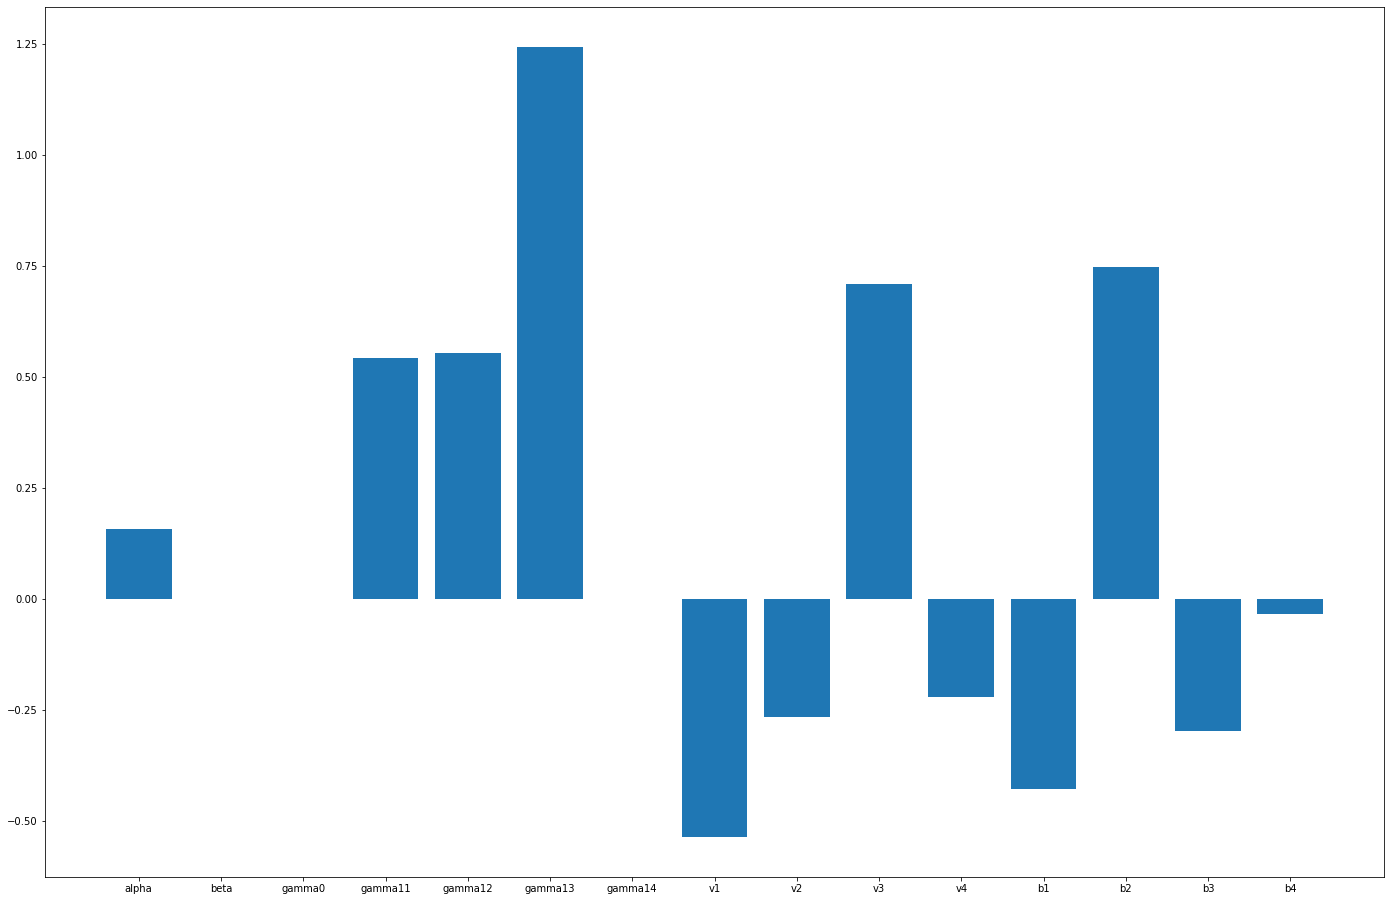

In [10]:
fig, axs = plt.subplots(1, figsize = (24,16))
plt.bar(par_names, res.x)
plt.show()

In [11]:
res.x

array([ 1.56863362e-01,  1.02590851e-04,  1.01231731e-04,  5.41478035e-01,
        5.52704171e-01,  1.24323226e+00,  1.00000000e-04, -5.37384703e-01,
       -2.67432387e-01,  7.08637264e-01, -2.20471567e-01, -4.27612108e-01,
        7.46939839e-01, -2.97761665e-01, -3.49992159e-02])

In [12]:
w = SRN_garch_hvec(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6], res.x[7], res.x[8], res.x[9], res.x[10], res.x[11], res.x[12], res.x[13], res.x[14], func_choice, returns)[1]

In [13]:
s = SRN_garch_hvec(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6], res.x[7], res.x[8], res.x[9], res.x[10], res.x[11], res.x[12], res.x[13], res.x[14], func_choice, returns)[0]

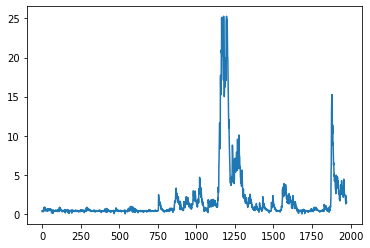

In [14]:
plt.plot(w[40:])

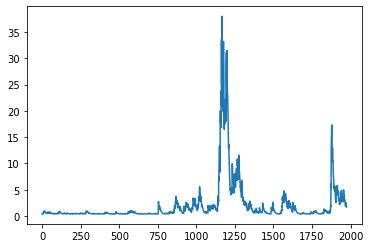

In [15]:
plt.plot(s[40:])

In [16]:
max(SRN_garch_hvec(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6], res.x[7], res.x[8], res.x[9], res.x[10], res.x[11], res.x[12], res.x[13], res.x[14], sigmoid, returns)[2][:,3][40:])

0.44380382724590317

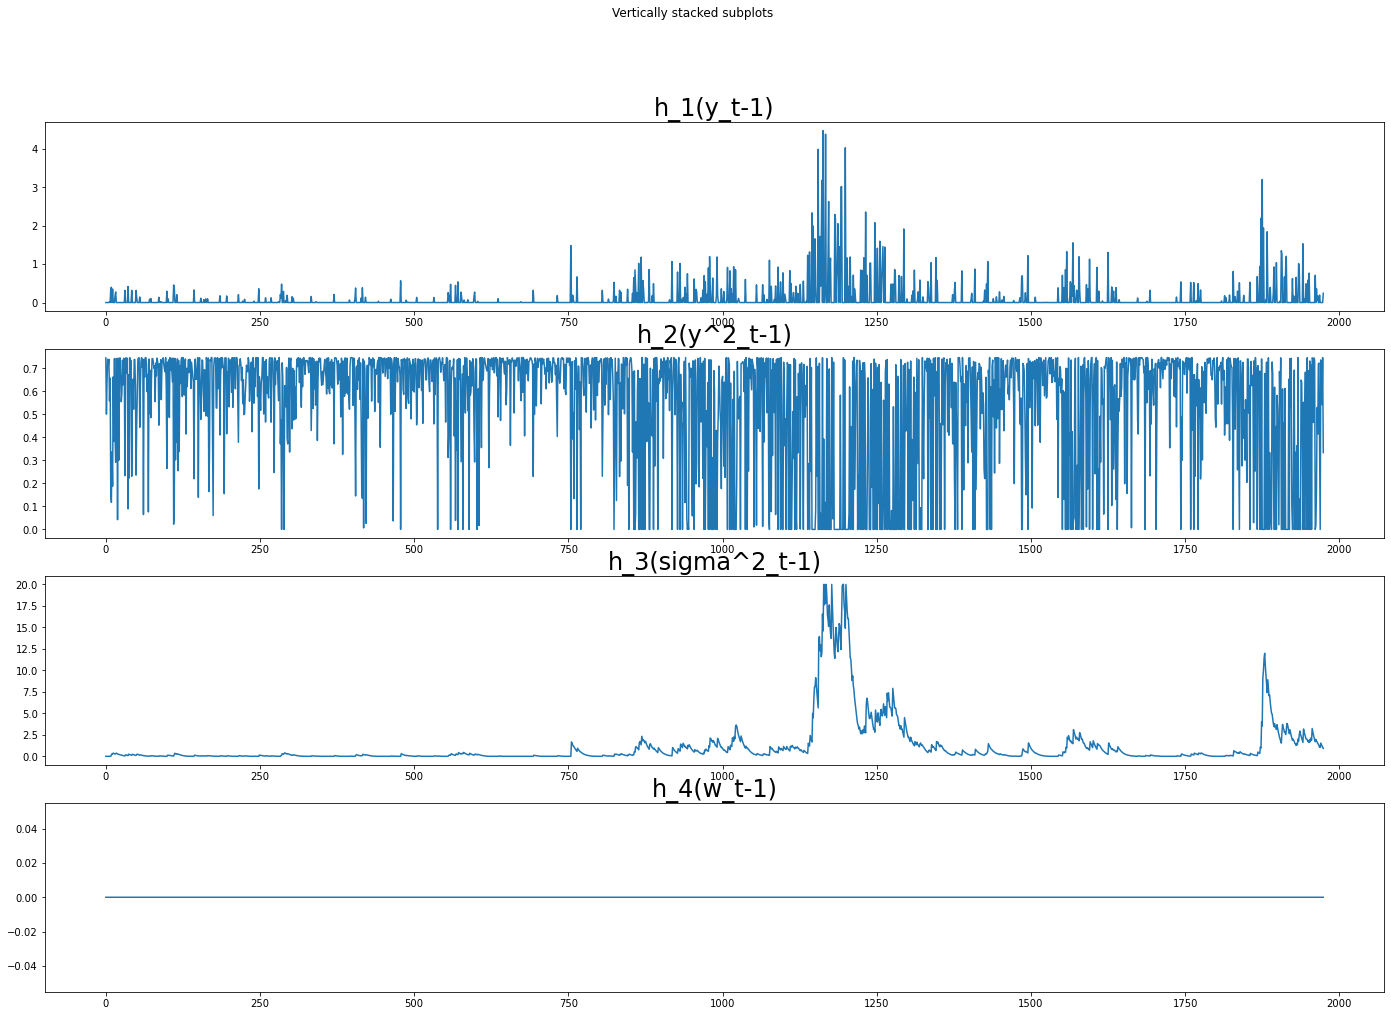

In [17]:
titles = ["h_1(y_t-1)", "h_2(y^2_t-1)", "h_3(sigma^2_t-1)" , "h_4(w_t-1)"]
fig, axs = plt.subplots(4,1, figsize = (24,16))
fig.suptitle('Vertically stacked subplots')
for i in range(4):
    axs[i].plot(SRN_garch_hvec(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6], res.x[7], res.x[8], res.x[9], res.x[10], res.x[11], res.x[12], res.x[13], res.x[14], func_choice, returns)[2][:,i][40:])
    axs[i].set_title(titles[i], size = 24)

# Model 2 (similar to authors with additional squared $y$ and lagged $w_{t-1}$)

\begin{align}
w_t = \gamma_0 + \gamma_1 h_t
\end{align}
$\gamma_1$ is a scalar and $h_t$
\begin{align}
    h_t=    \phi(v_1 y_{t-1} + v_2 y_{t-1}^2 + v_3 \sigma_{t-1}^2 + v_4 w_{t-1}) \\
\end{align}



In [18]:
def SRN_garch_h_scale(alpha, beta, gamma0, gamma1, v_1, v_2, v_3, v_4, nun_lin_func, returns):
    iT = len(returns)
    sigma_2 = np.zeros(iT)
    w = np.zeros(iT)
    h = np.zeros(iT)
    for i in range(iT):
        if i == 0:
            sigma_2[i] = 0.1/(1- alpha - beta)
            h[i] = 0.1/(1- alpha - beta)
            w[i] = 0.1/(1- alpha - beta)
        else:
            h[i] = nun_lin_func(v_1 * returns[i-1] + v_2 * returns[i-1]**2 + v_3 * sigma_2[i-1] + v_4 * w[i-1])
            w[i] = gamma0 + gamma1 * h[i]
            sigma_2[i] = w[i] + alpha * returns[i-1]**2 + beta * sigma_2[i-1]
    return sigma_2, w, h

def SRN_garch_hsca_loglike(start_v, nun_lin_func, returns):
    iT = len(returns)
    alpha = start_v[0]
    beta = start_v[1]
    gamma0 = start_v[2]
    gamma1 = start_v[3]
    v_1 = start_v[4]
    v_2 = start_v[5]
    v_3 = start_v[6]
    v_4 = start_v[7]
    
    sigma_2 = SRN_garch_h_scale(alpha, beta, gamma0, gamma1, v_1, v_2, v_3, v_4, nun_lin_func, returns)[0]
    LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)
    return LogL

In [19]:
cons = ({"type": "ineq", "func" : lambda x: np.array(x)})
vP0 = (0.1, 0.25, 0.52, 0.1 , 0.1, 0.1, 0.1, 0.1)
my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 3),  (0.0001, 3) , (-10, 10), (-10, 10), (-10,10)  ,(-10,10 ))

res = opt.minimize(SRN_garch_hsca_loglike, vP0, args = (relu, returns),
                  bounds = my_bounds,
                   method = "Nelder-Mead",
                  options = {"disp": True, "maxiter": 500000})

par_names = ["alpha", "beta", "gamma0", "gamma1",  "v1",  "v2",  "v3",  "v4"]
"""
plt.bar(par_names, res.x)
plt.show()

plt.bar(par_names[4:], res.x[4:])
plt.show()"""

C:\Users\mobem\AppData\Local\Temp\ipykernel_13584\4097942796.py:29: RuntimeWarning: invalid value encountered in log
  LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)


Optimization terminated successfully.
         Current function value: 1946.237342
         Iterations: 737
         Function evaluations: 1117


'\nplt.bar(par_names, res.x)\nplt.show()\n\nplt.bar(par_names[4:], res.x[4:])\nplt.show()'

In [20]:
res.x

array([ 0.1058416 ,  0.85680509,  0.01927808,  1.09519819,  0.09108776,
       -1.16336322,  0.08618787,  0.19239977])

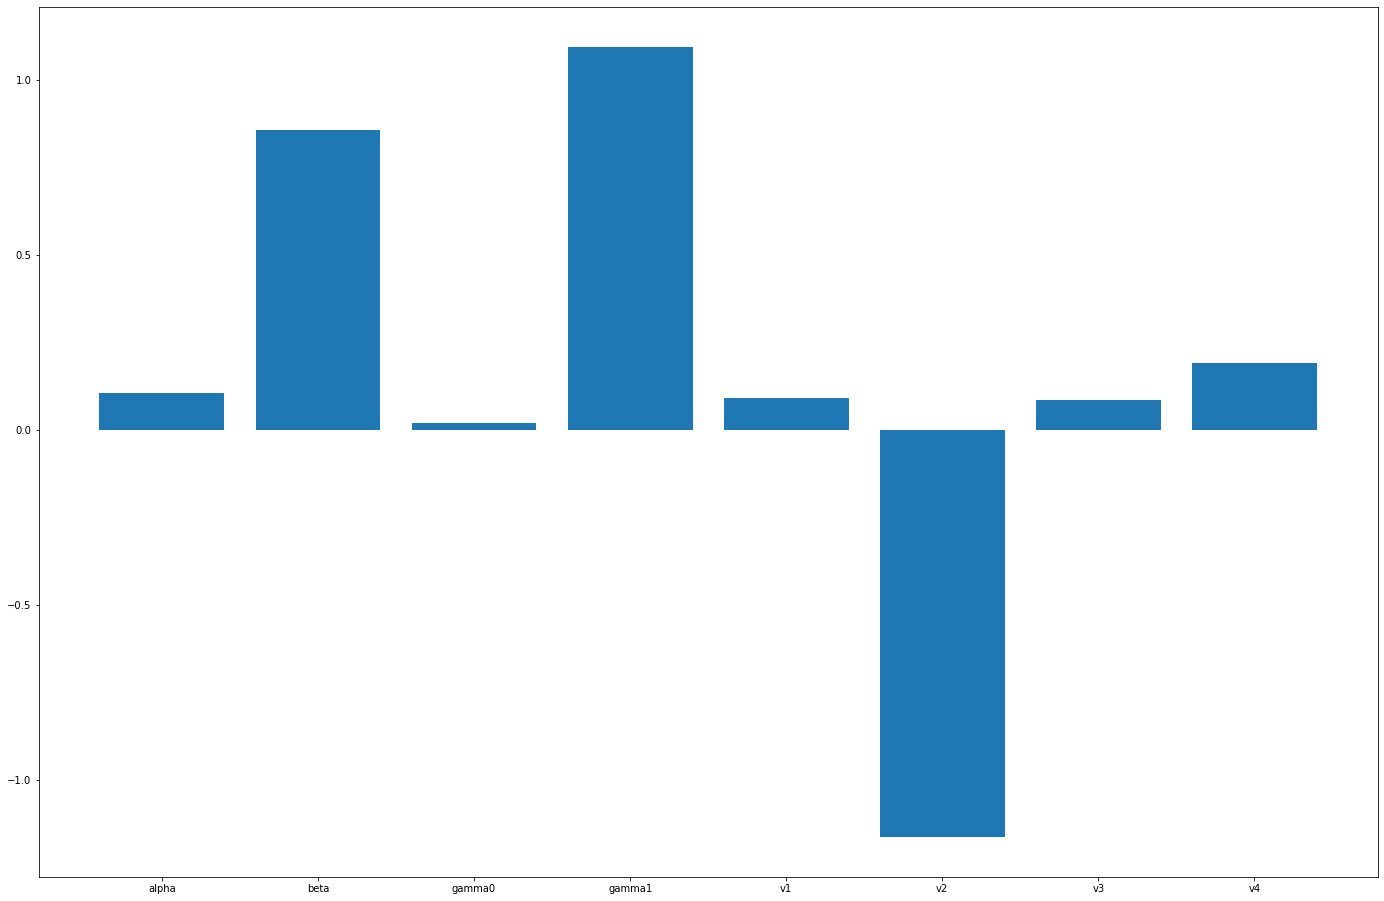

In [21]:
fig, axs = plt.subplots(1, figsize = (24,16))
plt.bar(par_names, res.x)
plt.show()

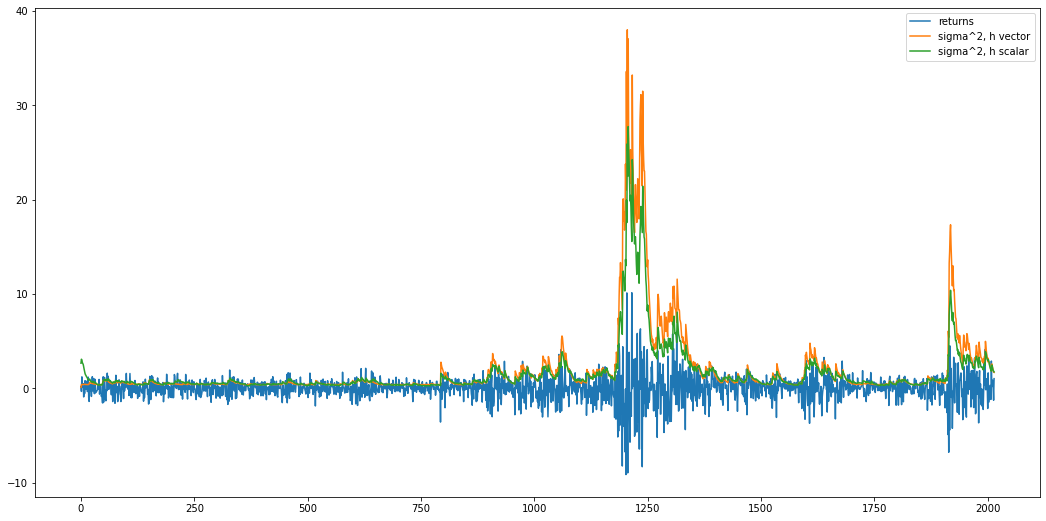

In [22]:
plt.figure(figsize=(18,9))
plt.plot(returns, label = "returns")
plt.plot(s, label = "sigma^2, h vector")
plt.plot(SRN_garch_h_scale(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6], res.x[7], relu, returns)[0], label = "sigma^2, h scalar")
plt.legend()
plt.show()

h scalar is more sensitive to high-volatility-periods?
